# Parte 1 - DataFrame
Catharina Bender Rodrigues

OBS.: Na linha 30 da célula onde é calulado o sigma para o filtro, teve um erro de digitção que devo ter feito na hora de finalizar e compilar para enviar o notebook para github. foi trocada nesta versao.

In [215]:
# Importar bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# [1] Leitura do Arquivo LHE

In [216]:
# Função para ler arquivo LHE
# Foi feito o upload dos arquivos de sinal e fundo no espaço do notebook
# Nome do arquivo de SINAL: de "unweighted_events.lhe" para "sinal.lhe"
# Nome do arquivo de FUNDO: de "unweighted_events.lhe" para "fundo.lhe"

def read_lhe(filename):
    events = []
    with open(filename, 'r') as f:
        lines = f.readlines()

    inside_event = False
    event_id = -1  # contador de eventos
    for line in lines:
        if "<event>" in line:
            inside_event = True
            particles = []
            event_id += 1
            continue
        if "</event>" in line:
            inside_event = False
            events.append(particles)
            continue
        if inside_event:
            parts = line.strip().split()
            if len(parts) > 10:  # linha de partícula
                pid = int(parts[0])          # Particle ID
                status = int(parts[1])       # Status da partícula
                px, py, pz, E, m = map(float, parts[6:11])
                particles.append({
                    "event_id": event_id,    # Identificador do evento
                    "pid": pid,              # Particle ID
                    "status": status,        # Status extraído do LHE
                    "px": px,                # Momento X
                    "py": py,                # Momento Y
                    "pz": pz,                # Momento Z
                    "E": E,                  # Energia total
                    "m": m,                  # Massa invariante
                    "pT": np.sqrt(px**2 + py**2)  # Momento transversal
                })
    # Achata lista de eventos em lista de partículas
    return pd.DataFrame([p for ev in events for p in ev])

In [217]:
# Ler sinal e fundo
df_signal = read_lhe("sinal.lhe")
df_background = read_lhe("fundo.lhe")

# [2a] Investigação Preliminar do Arquivo

In [218]:
# Número total de eventos únicos no primeiro DataFrame (df_signal)
num_events_signal = df_signal["event_id"].nunique()

print(f"Número total de eventos no sinal: {num_events_signal}")

Número total de eventos no sinal: 10000


In [219]:
# Número total de eventos únicos no DataFrame de fundo
num_events_background = df_background["event_id"].nunique()

print(f"Número total de eventos no fundo: {num_events_background}")


Número total de eventos no fundo: 10000


# [2b] Investigação Preliminar dos Eventos

In [220]:
# Contagem de partículas por status no sinal
tabela_signal = df_signal.groupby("status")["pid"].value_counts().unstack(fill_value=0)

# Contagem de partículas por status no fundo
tabela_background = df_background.groupby("status")["pid"].value_counts().unstack(fill_value=0)

print("Tabela de partículas no sinal:")
print(tabela_signal)

print("\nTabela de partículas no fundo:")
print(tabela_background)

Tabela de partículas no sinal:
pid       -13    -11  -4   -3    -2    -1     1     2    3    4      11  \
status                                                                    
-1          0      0  284  779  3634  5303  5303  3634  779  284      0   
 1      10000  10000    0    0     0     0     0     0    0    0  10000   
 2          0      0    0    0     0     0     0     0    0    0      0   

pid        13     23  
status                
-1          0      0  
 1      10000      0  
 2          0  20000  

Tabela de partículas no fundo:
pid       -13    -11   -4   -3    -2   -1    1     2    3     4      11     13
status                                                                        
-1          0      0  1375  223  7663  739  739  7663  223  1375      0      0
 1      10000  10000     0    0     0    0    0     0    0     0  10000  10000


____________
## Processo do Sinal
____________
Partículas envolvidas
- Léptons:
  - Elétron (pid = 11), pósitron (pid = -11)
  - Múon (pid = 13), anti-múon (pid = -13)
- Quarks:
  - Quarks leves (pid = ±1, ±2, ±3, ±4 → u, d, s, c)
- Ressonância:
  - Bóson Z (pid = 23)

____________
- `status = -1`: partículas iniciais (quarks ou léptons que participam da colisão, mas nestes dados, apenas QUARKS).
- `status = 1`: partículas finais detectáveis (resultados do decaimento do bóson Z: pares de léptons ou pares de quarks, mas neste dados, apenas LÉPTONS).
- `status = 2`: intermediárias (a ressonância Z que é produzida e depois decai).
____________

$pp\rightarrow q \bar{q} \rightarrow Z\rightarrow \ell ^+\ell ^-\quad (\ell =e,\mu )$

____________

____________
## Processo do Fundo
____________
Partículas envolvidas
- Léptons:
  - Elétron (pid = 11), pósitron (pid = -11)
  - Múon (pid = 13), anti-múon (pid = -13)
- Quarks:
  - Quarks leves (pid = ±1, ±2, ±3, ±4 → u, d, s, c)
- Ressonância:
  - Não há o bóson Z real (pid = 23) nos dados de fundo.
  - O processo é mediado por um fóton virtual ($\gamma ^*$) ou um Z fora da ressonância.

Isso indica que o fundo corresponde a produção direta de pares de léptons via interação eletrofraca (processo Drell–Yan), sem passar por uma ressonância intermediária.

____________
- `status = -1`: partículas iniciais: apenas quarks vindos dos prótons.
- `status = 1`: partículas finais detectáveis: pares de léptons (e⁺e⁻ ou μ⁺μ⁻)
- `status = 2`: nao tem.
____________

$pp\; \; \rightarrow \; \; q\bar {q}\; \; \rightarrow \; \; \gamma ^*/Z^*\; \; \rightarrow \; \; \ell ^+\ell ^-\quad (\ell =e,\mu )$

____________

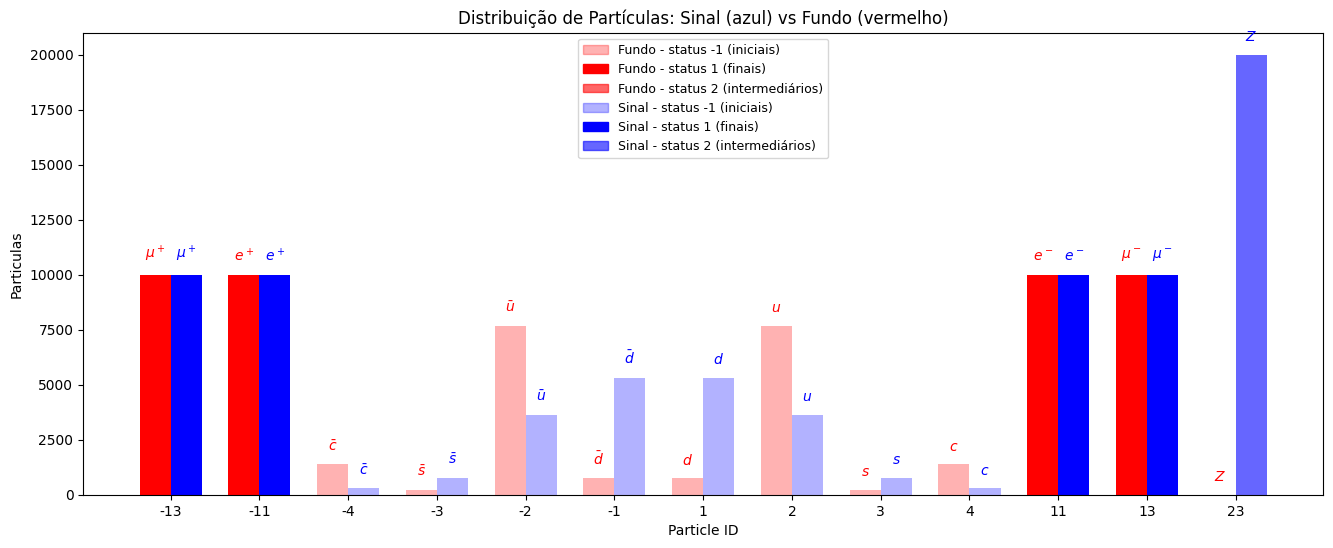

In [221]:
import matplotlib.patches as mpatches

# Dicionário PID → Nome da partícula em LaTeX
pid_names_latex = {
    11: r"$e^-$", -11: r"$e^+$",
    13: r"$\mu^-$", -13: r"$\mu^+$",
    2: r"$u$", -2: r"$\bar{u}$",
    4: r"$c$", -4: r"$\bar{c}$",
    1: r"$d$", -1: r"$\bar{d}$",
    3: r"$s$", -3: r"$\bar{s}$",
    23: r"$Z$",
}
# Agrupar por pid e status
counts_signal = df_signal.groupby(["pid","status"]).size().reset_index(name="count")
counts_background = df_background.groupby(["pid","status"]).size().reset_index(name="count")

# Transparências por status
alpha_map = {-1:0.3, 1:1.0, 2:0.6}

# PIDs únicos
pids = sorted(set(counts_signal["pid"]).union(set(counts_background["pid"])))
x = np.arange(len(pids))

bar_width = 0.35

plt.figure(figsize=(16,6))

# Plotar barras para cada status

for status in [-1,1,2]:
    # Fundo
    fundo_vals = [counts_background[(counts_background.pid==pid) & (counts_background.status==status)]["count"].sum() for pid in pids]
    plt.bar(x-bar_width/2, fundo_vals, width=bar_width, color='red', alpha=alpha_map[status])

    # Sinal
    sinal_vals = [counts_signal[(counts_signal.pid==pid) & (counts_signal.status==status)]["count"].sum() for pid in pids]
    plt.bar(x+bar_width/2, sinal_vals, width=bar_width, color='blue', alpha=alpha_map[status])

# Adicionar rótulos LaTeX em cima das barras
for i,pid in enumerate(pids):
    total_sinal = counts_signal[counts_signal.pid==pid]["count"].sum()
    total_fundo = counts_background[counts_background.pid==pid]["count"].sum()
    if pid in pid_names_latex:
        plt.text(i-bar_width/2, total_fundo+500, pid_names_latex[pid], ha='center', va='bottom', fontsize=10, color='red')
        plt.text(i+bar_width/2, total_sinal+500, pid_names_latex[pid], ha='center', va='bottom', fontsize=10, color='blue')

plt.xticks(x, pids)
plt.xlabel("Particle ID")
plt.ylabel("Particulas")
plt.title("Distribuição de Partículas: Sinal (azul) vs Fundo (vermelho)")

# Criar legenda com gradiente de cores (status)
legend_patches = [
    mpatches.Patch(color='red', alpha=alpha_map[-1], label="Fundo - status -1 (iniciais)"),
    mpatches.Patch(color='red', alpha=alpha_map[1], label="Fundo - status 1 (finais)"),
    mpatches.Patch(color='red', alpha=alpha_map[2], label="Fundo - status 2 (intermediários)"),
    mpatches.Patch(color='blue', alpha=alpha_map[-1], label="Sinal - status -1 (iniciais)"),
    mpatches.Patch(color='blue', alpha=alpha_map[1], label="Sinal - status 1 (finais)"),
    mpatches.Patch(color='blue', alpha=alpha_map[2], label="Sinal - status 2 (intermediários)"),
]

plt.legend(handles=legend_patches, loc="upper center", fontsize=9)
plt.show()


# [3] Exploração do Conteúdo

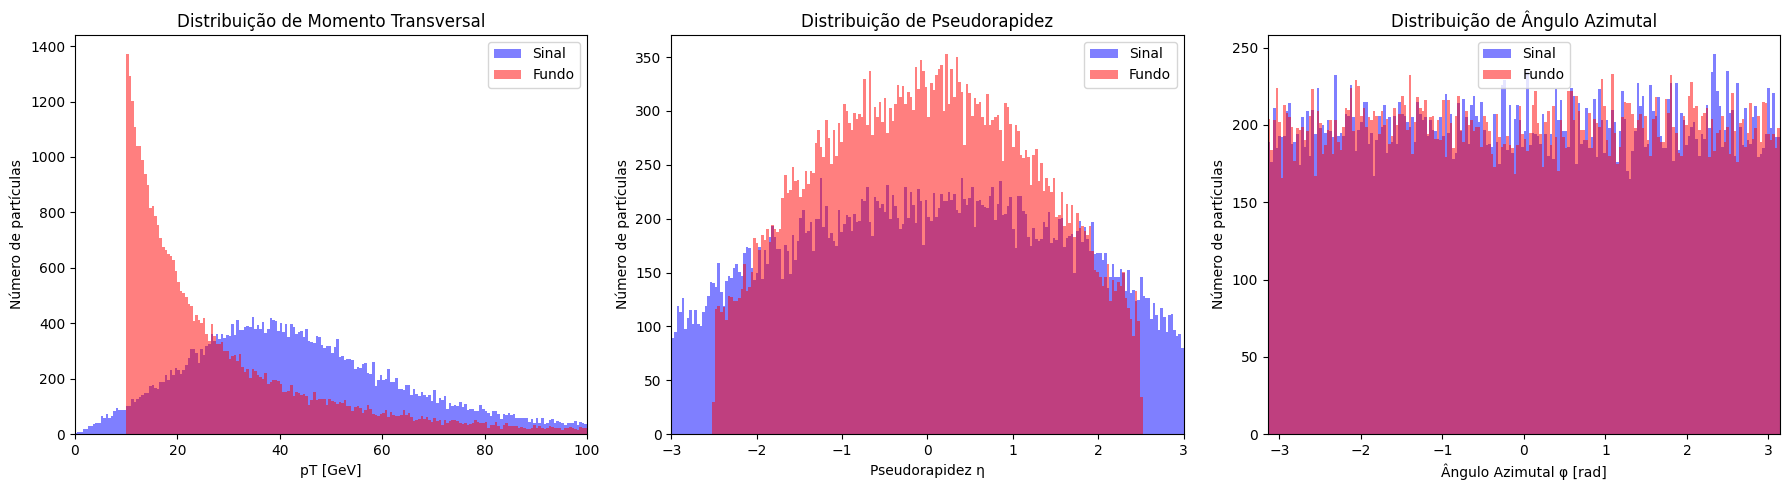

In [222]:
# Selecionar apenas partículas finais (status = 1), excluindo neutrinos (pid = ±12, ±14, ±16)
final_signal = df_signal[(df_signal["status"] == 1) & (~df_signal["pid"].isin([12, -12, 14, -14, 16, -16]))]
final_background = df_background[(df_background["status"] == 1) & (~df_background["pid"].isin([12, -12, 14, -14, 16, -16]))]

# Calcular pseudorapidez e phi
def compute_kinematics(df):
    p = np.sqrt(df["px"]**2 + df["py"]**2 + df["pz"]**2)
    eta = 0.5 * np.log((p + df["pz"]) / (p - df["pz"] + 1e-12))  # evitar divisão por zero
    phi = np.arctan2(df["py"], df["px"])
    df = df.copy()
    df["eta"] = eta
    df["phi"] = phi
    return df

final_signal = compute_kinematics(final_signal)
final_background = compute_kinematics(final_background)

# Histogramas comparativos
fig, axs = plt.subplots(1, 3, figsize=(18,5))

# pT
axs[0].hist(final_signal["pT"], bins=200, range=(0,100), alpha=0.5, color="blue", label="Sinal")
axs[0].hist(final_background["pT"], bins=200, range=(0,100), alpha=0.5, color="red", label="Fundo")
axs[0].set_xlabel("pT [GeV]")
axs[0].set_ylabel("Número de partículas")
axs[0].set_title("Distribuição de Momento Transversal")
axs[0].set_xlim(0,100)
axs[0].legend()

# η
axs[1].hist(final_signal["eta"], bins=200, range=(-3,3), alpha=0.5, color="blue", label="Sinal")
axs[1].hist(final_background["eta"], bins=200, range=(-3,3), alpha=0.5, color="red", label="Fundo")
axs[1].set_xlabel("Pseudorapidez η")
axs[1].set_ylabel("Número de partículas")
axs[1].set_title("Distribuição de Pseudorapidez")
axs[1].set_xlim(-3,3)
axs[1].legend()

# φ
axs[2].hist(final_signal["phi"], bins=200, range=(-np.pi, np.pi), alpha=0.5, color="blue", label="Sinal")
axs[2].hist(final_background["phi"], bins=200, range=(-np.pi, np.pi), alpha=0.5, color="red", label="Fundo")
axs[2].set_xlabel("Ângulo Azimutal φ [rad]")
axs[2].set_ylabel("Número de partículas")
axs[2].set_title("Distribuição de Ângulo Azimutal")
axs[2].set_xlim(-np.pi,np.pi)
axs[2].legend()

plt.tight_layout()
plt.show()

In [223]:
# Eventos que entram em cada histograma (pelas faixas)
evt_pt_signal = final_signal[(final_signal["pT"] >= 0) & (final_signal["pT"] <= 100)]["event_id"].nunique()
evt_pt_background = final_background[(final_background["pT"] >= 0) & (final_background["pT"] <= 100)]["event_id"].nunique()

evt_eta_signal = final_signal[(final_signal["eta"] >= -3) & (final_signal["eta"] <= 3)]["event_id"].nunique()
evt_eta_background = final_background[(final_background["eta"] >= -3) & (final_background["eta"] <= 3)]["event_id"].nunique()

evt_phi_signal = final_signal[(final_signal["phi"] >= -np.pi) & (final_signal["phi"] <= np.pi)]["event_id"].nunique()
evt_phi_background = final_background[(final_background["phi"] >= -np.pi) & (final_background["phi"] <= np.pi)]["event_id"].nunique()

print("Eventos representados (pT 0–100 GeV): Sinal =", evt_pt_signal, "| Fundo =", evt_pt_background, " - - Event S / Event F = ", round(evt_pt_signal / evt_pt_background, 4))
print("Eventos representados (η −3–+3): Sinal =", evt_eta_signal, "| Fundo =", evt_eta_background, " - - Event S / Event F = ", round(evt_eta_signal / evt_eta_background, 4))
print("Eventos representados (φ −π–+π): Sinal =", evt_phi_signal, "| Fundo =", evt_phi_background, " - - Event S / Event F = ", round(evt_phi_signal / evt_phi_background, 4))


Eventos representados (pT 0–100 GeV): Sinal = 9995 | Fundo = 9988  - - Event S / Event F =  1.0007
Eventos representados (η −3–+3): Sinal = 9973 | Fundo = 10000  - - Event S / Event F =  0.9973
Eventos representados (φ −π–+π): Sinal = 10000 | Fundo = 10000  - - Event S / Event F =  1.0


Os histogramas gerados não apresentam 100% dos eventos, no entando, as janelas de valores solicitados redúz para 99,95% (sinal) e 99,88% (fundo) dos eventos com o pT limitado entre 0 e 100 GeV, e 99,73% (sinal) para a restrição de η entre -3 e +3. Este nao é um corte/filtro significativo para se tirar conclusões. Outra forma de avaliar é a razão entre os eventos do sinal/fundo dos intervalos selecionado. Um bom filtro é um filtro que aumenta esta razão



# [4] Filtros e Cortes Cinemáticos

# Teste de outros cortes cinemático

### Pegar apenas eventos em que os leptons possuem um momento transversal mínimo (pT)

In [224]:
# Selecionar apenas léptons finais (status=1, sem neutrinos)
leptons_signal = final_signal[final_signal["pid"].isin([11, -11, 13, -13])]
leptons_background = final_background[final_background["pid"].isin([11, -11, 13, -13])]

# Função para aplicar corte em pT mínimo por lépton
def apply_pt_cut(leptons_df, pt_min=25):
    # Agrupar por evento
    surviving_events = []
    for evt_id, group in leptons_df.groupby("event_id"):
        # Verificar se todos os léptons do evento passam no corte
        if (group["pT"] > pt_min).all():
            surviving_events.append(evt_id)
    return surviving_events

# Testar diferentes valores de corte
pt_thresholds = range(20, 40, 2)

results = []
for pt_min in pt_thresholds:
    surv_signal = apply_pt_cut(leptons_signal, pt_min)
    surv_background = apply_pt_cut(leptons_background, pt_min)

    eff_signal = len(surv_signal) / leptons_signal["event_id"].nunique()
    eff_background = len(surv_background) / leptons_background["event_id"].nunique()

    results.append({
        "pT_l_min [GeV]": pt_min,
        "Event Sinal": len(surv_signal),
        "Event Fundo": len(surv_background),
        "Eff Sinal": round(eff_signal, 4),
        "Eff Fundo": round(eff_background, 4),
        "Razão S/F": round(len(surv_signal) / max(len(surv_background),1), 4)
    })

# Mostrar tabela de resultados
df_results = pd.DataFrame(results)
print(df_results)


   pT_l_min [GeV]  Event Sinal  Event Fundo  Eff Sinal  Eff Fundo  Razão S/F
0              20         6311         1381     0.6311     0.1381     4.5699
1              22         5664         1067     0.5664     0.1067     5.3083
2              24         4892          823     0.4892     0.0823     5.9441
3              26         4211          650     0.4211     0.0650     6.4785
4              28         3464          525     0.3464     0.0525     6.5981
5              30         2812          417     0.2812     0.0417     6.7434
6              32         2216          333     0.2216     0.0333     6.6547
7              34         1690          270     0.1690     0.0270     6.2593
8              36         1253          225     0.1253     0.0225     5.5689
9              38          914          197     0.0914     0.0197     4.6396


Um pT_min de 30 GeV para os léptons aumentou a Razão S/F de 1.00 para 6.74.

In [225]:
# Criando um dataframe com os eventos selecionados

# Definir o corte ótimo
pt_min_opt = 30

# Obter lista de eventos sobreviventes no sinal e no fundo (apenas IDs)
surv_signal_ids = apply_pt_cut(leptons_signal, pt_min_opt)
surv_background_ids = apply_pt_cut(leptons_background, pt_min_opt)

# Agora filtrar o DataFrame original para pegar TODAS as partículas desses eventos
selected1_signal_full = final_signal[final_signal["event_id"].isin(surv_signal_ids)].copy()
selected1_background_full = final_background[final_background["event_id"].isin(surv_background_ids)].copy()

print("Eventos de sinal completos selecionados:", selected1_signal_full["event_id"].nunique())
print("Eventos de fundo completos selecionados:", selected1_background_full["event_id"].nunique())

# Mostrar algumas linhas como exemplo
print(selected1_signal_full.head(5))

Eventos de sinal completos selecionados: 2812
Eventos de fundo completos selecionados: 417
    event_id  pid  status         px         py         pz          E  \
36         4  -13       1 -65.032548 -23.570440  27.085545  74.286176   
37         4   13       1  33.177473 -28.346960  55.705245  70.762846   
38         4  -11       1 -24.355985  17.598839 -27.022028  40.411919   
39         4   11       1  56.211060  34.318560  19.279454  68.623204   
76         9  -13       1  16.975228 -27.472246 -18.399133  37.167485   

           m         pT       eta       phi  
36  0.105660  69.172234  0.382194 -2.793878  
37  0.105660  43.638227  1.064056 -0.707045  
38  0.000511  30.048846 -0.808324  2.515881  
39  0.000511  65.859296  0.288709  0.548126  
76  0.105660  32.293694 -0.542708 -1.017316  


### Testando outras formas de filtrar: através da massa invariante das particulas finais de cada evento

Esta resolução estava muito pequena, e com uma janela muito restrritiva, podemos perder eventos relevantes para a análise dos dados. Algumas referencias mostram um σ (resolução) da massa invariante de 1-2 GeV para os múons e 3-5 GeV para os elétrons, entao optou-se por uma janela de 4*σ = 4*1,22 = 4,88 GeV.

In [226]:
############ CÁLCULO DO SIGMA #############################################################################################################################################
from scipy.optimize import curve_fit

# construa m_ll dos pares selecionados (pT_min, qualidade, etc.)
def invariant_mass(l1, l2):
    E = l1["E"] + l2["E"]
    px = l1["px"] + l2["px"]
    py = l1["py"] + l2["py"]
    pz = l1["pz"] + l2["pz"]
    return np.sqrt(max(E**2 - (px**2 + py**2 + pz**2), 0))

def build_mll(df_full):
    leptons = df_full[df_full["pid"].isin([11,-11,13,-13])]
    mll = []
    for evt_id, g in leptons.groupby("event_id"):
        ls = g.to_dict("records")
        for i in range(len(ls)):
            for j in range(i+1, len(ls)):
                a, b = ls[i], ls[j]
                # mesmo sabor e cargas opostas
                if abs(a["pid"]) != abs(b["pid"]) or np.sign(a["pid"]) == np.sign(b["pid"]):
                    continue
                mll.append(invariant_mass(a,b))
    return np.array(mll)

# ajuste Gauss simples em janela ao redor do Z
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

m_signal = build_mll(selected1_signal_full)  # use seu df já filtrado ##### NESTA LINHA ESTAVA DANDO ERRO PQ ESTAVA O selected2_signal_full AO INVÉS DO selected1_signal_full
# escolha janela para o ajuste (ex.: 86–96 GeV)
mask = (m_signal > 82) & (m_signal < 100)
hist, edges = np.histogram(m_signal[mask], bins=500, range=(86,96))
centers = 0.5*(edges[:-1] + edges[1:])

# chute inicial
A0 = hist.max()
mu0 = 91.2
sigma0 = 5.0

popt, pcov = curve_fit(gauss, centers, hist, p0=[A0, mu0, sigma0])
A, mu, sigma = popt

print(f"Resolução estimada (σ) ≈ {sigma:.2f} GeV, pico em {mu:.2f} GeV")


Resolução estimada (σ) ≈ 1.32 GeV, pico em 91.24 GeV


In [227]:
# Função para calcular massa invariante de pares
def invariant_mass(l1, l2):
    E = l1["E"] + l2["E"]
    px = l1["px"] + l2["px"]
    py = l1["py"] + l2["py"]
    pz = l1["pz"] + l2["pz"]
    return np.sqrt(max(E**2 - (px**2 + py**2 + pz**2), 0))

# Função para aplicar janela de massa invariante
def apply_mass_window(df_full, mwin=(80,100)):
    surviving_events = []
    leptons = df_full[df_full["pid"].isin([11, -11, 13, -13])]
    for evt_id, group in leptons.groupby("event_id"):
        leptons_evt = group.to_dict("records")
        for i in range(len(leptons_evt)):
            for j in range(i+1, len(leptons_evt)):
                mll = invariant_mass(leptons_evt[i], leptons_evt[j])
                if mwin[0] < mll < mwin[1]:
                    surviving_events.append(evt_id)
                    break  # basta um par válido para aceitar o evento
    return surviving_events

# Aplicar janela de massa (em torno do valor de 91 GeV)
mass_Z = 91 # GeV
window = 4*sigma
mass_window = (mass_Z-window, mass_Z+window)
surv_signal_ids_mass = apply_mass_window(selected1_signal_full, mass_window)
surv_background_ids_mass = apply_mass_window(selected1_background_full, mass_window)

# Filtrar eventos completos novamente
selected2_signal_full = selected1_signal_full[selected1_signal_full["event_id"].isin(surv_signal_ids_mass)].copy()
selected2_background_full = selected1_background_full[selected1_background_full["event_id"].isin(surv_background_ids_mass)].copy()

print("Eventos de sinal após janela de massa:", selected2_signal_full["event_id"].nunique())
print("Eventos de fundo após janela de massa:", selected2_background_full["event_id"].nunique())
print("S/F = ", round(selected2_signal_full["event_id"].nunique() / selected2_background_full["event_id"].nunique(), 4))

# Mostrar algumas linhas como exemplo
print(selected2_signal_full.head(5))


Eventos de sinal após janela de massa: 2773
Eventos de fundo após janela de massa: 126
S/F =  22.0079
    event_id  pid  status         px         py         pz          E  \
36         4  -13       1 -65.032548 -23.570440  27.085545  74.286176   
37         4   13       1  33.177473 -28.346960  55.705245  70.762846   
38         4  -11       1 -24.355985  17.598839 -27.022028  40.411919   
39         4   11       1  56.211060  34.318560  19.279454  68.623204   
76         9  -13       1  16.975228 -27.472246 -18.399133  37.167485   

           m         pT       eta       phi  
36  0.105660  69.172234  0.382194 -2.793878  
37  0.105660  43.638227  1.064056 -0.707045  
38  0.000511  30.048846 -0.808324  2.515881  
39  0.000511  65.859296  0.288709  0.548126  
76  0.105660  32.293694 -0.542708 -1.017316  


Esta Razão de Eventos Sinal/Fundo de aproximadadamente 23,8 parece promissor pois significa que foi possível descartar mais eventos irrelevantes do fundo do que do sinal.

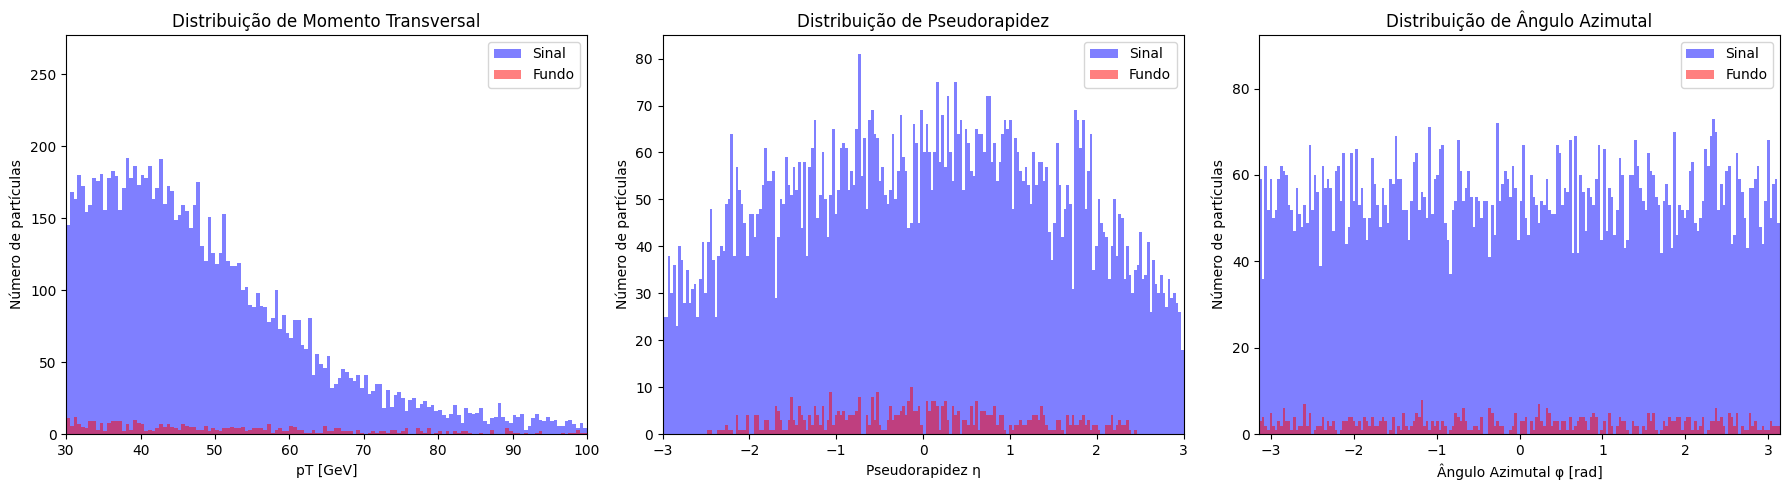

In [228]:
selected2_signal = compute_kinematics(selected2_signal_full)
selected2_background = compute_kinematics(selected2_background_full)

# Histogramas comparativos
fig, axs = plt.subplots(1, 3, figsize=(18,5))

# pT
axs[0].hist(selected2_signal["pT"], bins=200, range=(0,100), alpha=0.5, color="blue", label="Sinal")
axs[0].hist(selected2_background["pT"], bins=200, range=(0,100), alpha=0.5, color="red", label="Fundo")
axs[0].set_xlabel("pT [GeV]")
axs[0].set_ylabel("Número de partículas")
axs[0].set_title("Distribuição de Momento Transversal")
axs[0].set_xlim(pt_min_opt,100)
axs[0].set_ylim(0,selected2_signal_full["event_id"].nunique()/10)
axs[0].legend()

# η
axs[1].hist(selected2_signal["eta"], bins=200, range=(-3,3), alpha=0.5, color="blue", label="Sinal")
axs[1].hist(selected2_background["eta"], bins=200, range=(-3,3), alpha=0.5, color="red", label="Fundo")
axs[1].set_xlabel("Pseudorapidez η")
axs[1].set_ylabel("Número de partículas")
axs[1].set_title("Distribuição de Pseudorapidez")
axs[1].set_xlim(-3,3)
axs[1].legend()

# φ
axs[2].hist(selected2_signal["phi"], bins=200, range=(-np.pi, np.pi), alpha=0.5, color="blue", label="Sinal")
axs[2].hist(selected2_background["phi"], bins=200, range=(-np.pi, np.pi), alpha=0.5, color="red", label="Fundo")
axs[2].set_xlabel("Ângulo Azimutal φ [rad]")
axs[2].set_ylabel("Número de partículas")
axs[2].set_title("Distribuição de Ângulo Azimutal")
axs[2].set_xlim(-np.pi,np.pi)
axs[2].set_ylim(0,selected2_signal_full["event_id"].nunique()/30)
axs[2].legend()

plt.tight_layout()
plt.show()

Nos histogramas acima pode ser observar um redução significativa do fundo com relação ao sinal.

# Parte 2 - DataFrame
Catharina Bender Rodrigues

# [5] CONSERVAÇÃO DE ENERGIA

In [229]:
# --- [5] CONSERVAÇÃO DE ENERGIA ---
# Calcular a variável de Mandelstam "s" para eventos específicos

# Função para calcular s para um evento
def compute_s(event_df):
    E_total = event_df["E"].sum()
    px_total = event_df["px"].sum()
    py_total = event_df["py"].sum()
    pz_total = event_df["pz"].sum()
    s = E_total**2 - (px_total**2 + py_total**2 + pz_total**2)
    return s

# Eventos que vamos analisar: 1 + 1000*i, i = [0,9]
event_indices = [1 + 1000*i for i in range(10)]

print("Valores da variável s para eventos selecionados (Sinal):")
for evt_id in event_indices:
    evt_particles = final_signal[final_signal["event_id"] == evt_id]
    if not evt_particles.empty:
        s_value = compute_s(evt_particles)
        print(f"Evento {evt_id}: s = {s_value:.2f} GeV^2")
    else:
        print(f"Evento {evt_id}: não possui partículas finais válidas.")

print("\nValores da variável s para eventos selecionados (Fundo):")
for evt_id in event_indices:
    evt_particles = final_background[final_background["event_id"] == evt_id]
    if not evt_particles.empty:
        s_value = compute_s(evt_particles)
        print(f"Evento {evt_id}: s = {s_value:.2f} GeV^2")
    else:
        print(f"Evento {evt_id}: não possui partículas finais válidas.")


Valores da variável s para eventos selecionados (Sinal):
Evento 1: s = 61659.04 GeV^2
Evento 1001: s = 44260.96 GeV^2
Evento 2001: s = 174740.10 GeV^2
Evento 3001: s = 146318.99 GeV^2
Evento 4001: s = 85734.72 GeV^2
Evento 5001: s = 80578.60 GeV^2
Evento 6001: s = 28883.46 GeV^2
Evento 7001: s = 106428.03 GeV^2
Evento 8001: s = 36466.67 GeV^2
Evento 9001: s = 74015.46 GeV^2

Valores da variável s para eventos selecionados (Fundo):
Evento 1: s = 11079.30 GeV^2
Evento 1001: s = 11501.50 GeV^2
Evento 2001: s = 25371.16 GeV^2
Evento 3001: s = 8889.78 GeV^2
Evento 4001: s = 4317.05 GeV^2
Evento 5001: s = 94841.52 GeV^2
Evento 6001: s = 3742.83 GeV^2
Evento 7001: s = 10917.15 GeV^2
Evento 8001: s = 4926.21 GeV^2
Evento 9001: s = 13638.30 GeV^2


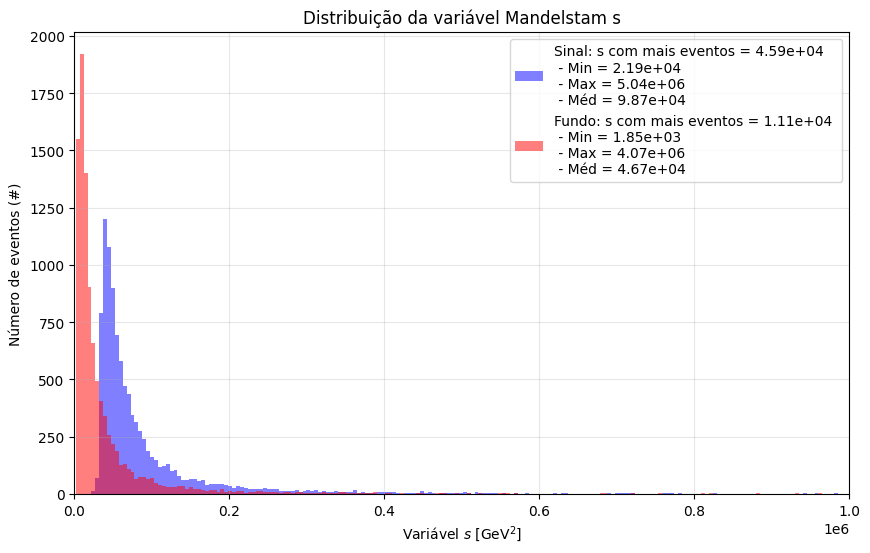

sqrt(s)_sinal =  214.2719289690298
sqrt(s)_fundo =  105.25823725473465


In [230]:
# --- [5] Distribuição da variável s para todos os eventos ---

# Calcular s para todos os eventos
def compute_s_all(df):
    s_values = []
    for evt_id, group in df.groupby("event_id"):
        s_values.append(compute_s(group))
    return np.array(s_values)

# Calcular para sinal e fundo
s_signal = compute_s_all(final_signal)
s_background = compute_s_all(final_background)

s_signal_min = s_signal.min()
s_signal_max = s_signal.max()
s_signal_med = s_signal.mean()
s_background_min = s_background.min()
s_background_max = s_background.max()
s_background_med = s_background.mean()

# Plotar histograma comparativo
plt.figure(figsize=(10,6))
bins = np.linspace(min(s_signal_min, s_background_min),
                   max(s_signal_max, s_background_max), 1000)


# Histograma (sem plotar ainda, para pegar contagens)
hist_signal, edges_signal = np.histogram(s_signal, bins=bins)
hist_background, edges_background = np.histogram(s_background, bins=bins)

# Encontrar pico (máximo)
idx_signal_peak = np.argmax(hist_signal)
idx_background_peak = np.argmax(hist_background)

s_signal_peak = 0.5 * (edges_signal[idx_signal_peak] + edges_signal[idx_signal_peak+1])
s_background_peak = 0.5 * (edges_background[idx_background_peak] + edges_background[idx_background_peak+1])

count_signal_peak = hist_signal[idx_signal_peak]
count_background_peak = hist_background[idx_background_peak]


plt.hist(s_signal, bins=bins, alpha=0.5, color="blue", label="Sinal: s com mais eventos = {:.2e} \n - Min = {:.2e} \n - Max = {:.2e} \n - Méd = {:.2e}".format(s_signal[idx_signal_peak], s_signal_min, s_signal_max, s_signal_med))
plt.hist(s_background, bins=bins, alpha=0.5, color="red", label="Fundo: s com mais eventos = {:.2e} \n - Min = {:.2e} \n - Max = {:.2e} \n - Méd = {:.2e}".format(s_background[idx_background_peak], s_background_min, s_background_max, s_background_med))

plt.xlabel(r"Variável $s$ [GeV$^2$]")
plt.ylabel("Número de eventos (#)")
plt.title("Distribuição da variável Mandelstam s")
plt.xlim(0, 1e6)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("sqrt(s)_sinal = ", (s_signal[idx_signal_peak])**(1/2))
print("sqrt(s)_fundo = ", (s_background[idx_background_peak])**(1/2))


Como é de se experar, os eventos do SINAL possuem um "s" consideravelmente maior que o de FUNDO, podendo ser observado no posicionamento dos picos de cada conjunto de dados, e também pela média dos "s"'s, onde o SINAL apresenta praticamente o dobro do "s" de FUNDO.

Isso é um indicador de como a energia das particulas geradas nos eventos/colisões do SINAL é muito maior do que as do FUNDO. Isso é o que permite a produção de particulas como o bóson Z, que pode ser observado no SINAL.

- Sinal ->  $\sqrt{s} = 214 GeV$
- Sinal ->  $\sqrt{s} = 105 GeV$

Diferença entre sinal e fundo está no mecanismo físico

Sinal: Processo foi gerado para produzir um Z pois a seção de choque para esse processo é alta na região da ressonância do Z ($qqˉ​→Z→ℓ+ℓ−$).


Fundo: Já qui podemos ter o Processo Drell-Yan contínuo ($qqˉ​→γ∗/Z∗→ℓ+ℓ−$), onde o par de léptons pode ter massa invariante em qualquer valor permitido pela energia, mas não há ressonância obrigatória. O Z pode aparecer como estado virtual, mas não necessariamente on-shell (real).

# [6] RECONSTRUÇÃO DE VARIÁVEIS

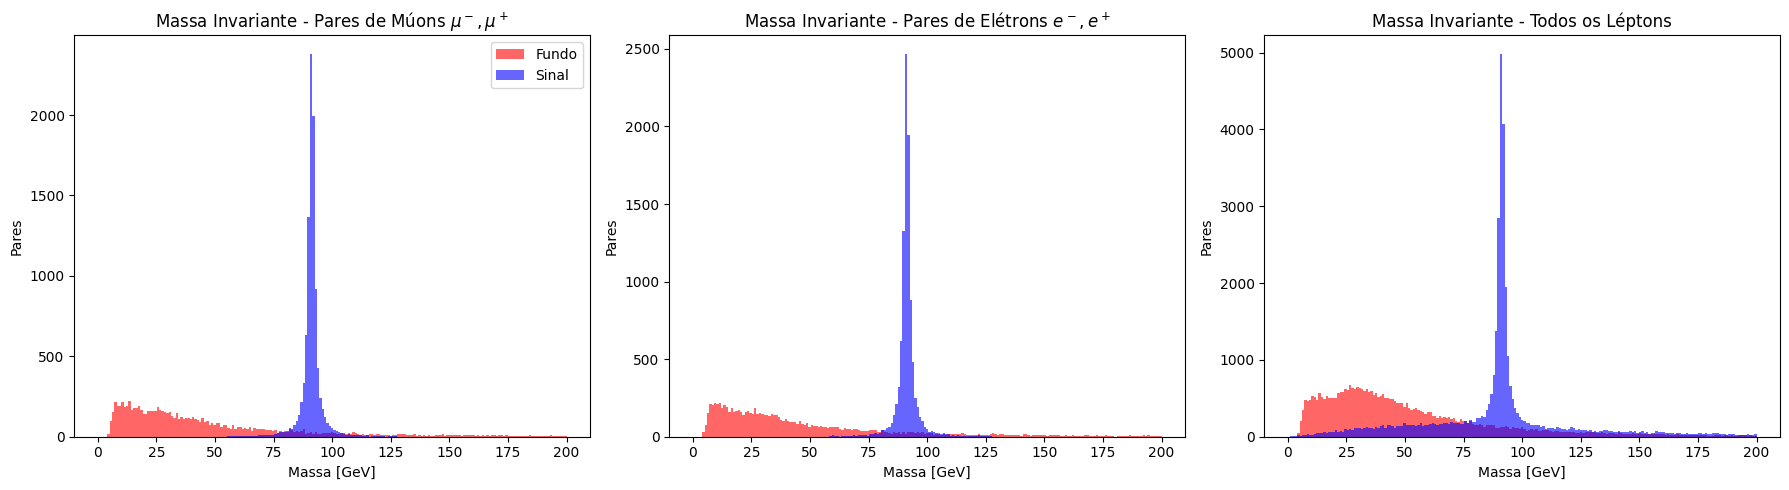

In [231]:

# --- [6] Histogramas combinados: múons, elétrons e todos os léptons ---
def build_mass_histograms_combined(signal_df, background_df):
    # Função auxiliar para calcular massas
    def get_masses_by_type(df):
        leptons = df[df["pid"].isin([11, -11, 13, -13])]
        m_muons, m_electrons, m_leptons = [], [], []
        for evt_id, group in leptons.groupby("event_id"):
            particles = group.to_dict("records")
            # Pares de múons
            muons = [p for p in particles if abs(p["pid"]) == 13]
            for i in range(len(muons)):
                for j in range(i+1, len(muons)):
                    if np.sign(muons[i]["pid"]) != np.sign(muons[j]["pid"]):
                        m_muons.append(invariant_mass(muons[i], muons[j]))
            # Pares de elétrons
            electrons = [p for p in particles if abs(p["pid"]) == 11]
            for i in range(len(electrons)):
                for j in range(i+1, len(electrons)):
                    if np.sign(electrons[i]["pid"]) != np.sign(electrons[j]["pid"]):
                        m_electrons.append(invariant_mass(electrons[i], electrons[j]))
            # Pares de léptons (muons + elétrons)
            for i in range(len(particles)):
                for j in range(i+1, len(particles)):
                    if np.sign(particles[i]["pid"]) != np.sign(particles[j]["pid"]):
                        m_leptons.append(invariant_mass(particles[i], particles[j]))
        return np.array(m_muons), np.array(m_electrons), np.array(m_leptons)

    # Obter massas para sinal e fundo
    m_muons_signal, m_electrons_signal, m_leptons_signal = get_masses_by_type(signal_df)
    m_muons_background, m_electrons_background, m_leptons_background = get_masses_by_type(background_df)

    # Criar figura com 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    bins = np.linspace(0, 200, 200)

    # --- Pares de múons ---
    axs[0].hist(m_muons_background, bins=bins, color="red", alpha=0.6, label="Fundo")
    axs[0].hist(m_muons_signal, bins=bins, color="blue", alpha=0.6, label="Sinal")
    axs[0].set_title("Massa Invariante - Pares de Múons "+r"$\mu^-,\mu^+$")
    axs[0].set_xlabel("Massa [GeV]")
    axs[0].set_ylabel("Pares")
    axs[0].legend()

    # --- Pares de elétrons ---
    axs[1].hist(m_electrons_background, bins=bins, color="red", alpha=0.6)
    axs[1].hist(m_electrons_signal, bins=bins, color="blue", alpha=0.6)
    axs[1].set_title("Massa Invariante - Pares de Elétrons "+r"$e^-,e^+$")
    axs[1].set_xlabel("Massa [GeV]")
    axs[1].set_ylabel("Pares")

    # --- Pares de léptons (muons + elétrons) ---
    axs[2].hist(m_leptons_background, bins=bins, color="red", alpha=0.6)
    axs[2].hist(m_leptons_signal, bins=bins, color="blue", alpha=0.6)
    axs[2].set_title("Massa Invariante - Todos os Léptons")
    axs[2].set_xlabel("Massa [GeV]")
    axs[2].set_ylabel("Pares")

    plt.tight_layout()
    plt.show()

# Chamar função para sinal e fundo filtrados
build_mass_histograms_combined(final_signal, final_background)

Como temos dois pares de léptons estáveis ao fim de cada evento, foi feito um terceiro histograma para verificar equivalência entre os processos.

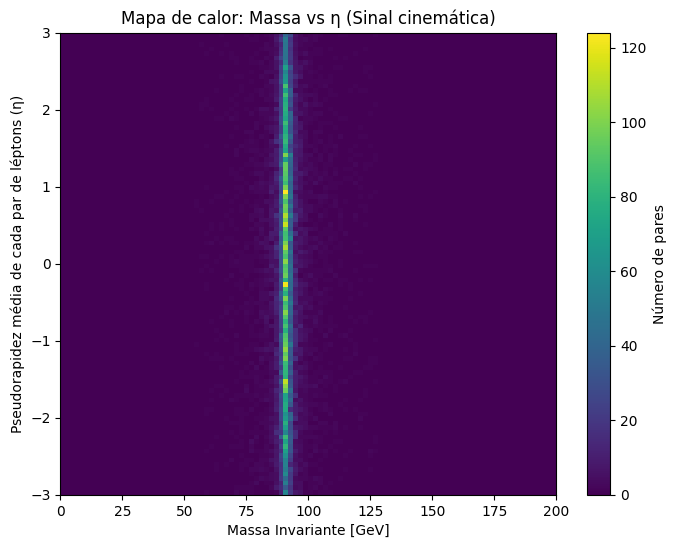

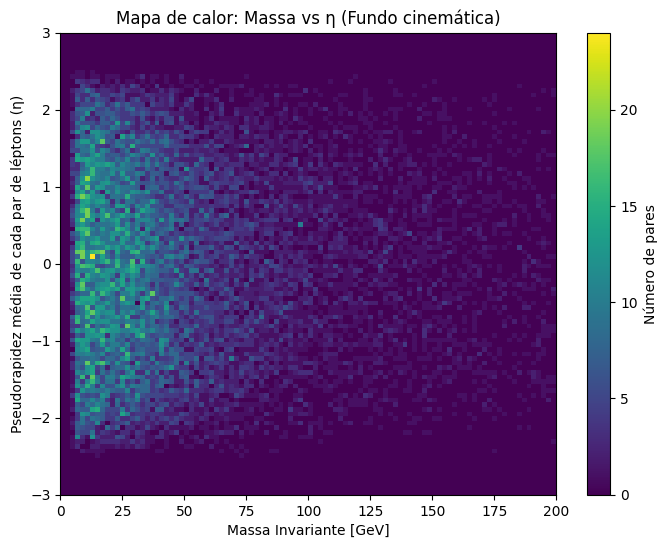

In [232]:
# --- [6] Histogramas 2D: Massa Invariante vs Pseudorapidez ---

def build_mass_eta_heatmap(df, label):
    leptons = df[df["pid"].isin([11, -11, 13, -13])]  # elétrons e múons
    masses = []
    etas = []

    for evt_id, group in leptons.groupby("event_id"):
        particles = group.to_dict("records")
        for i in range(len(particles)):
            for j in range(i+1, len(particles)):
                a, b = particles[i], particles[j]
                # Apenas pares com cargas opostas e mesmo tipo (elétron ou múon)
                if abs(a["pid"]) == abs(b["pid"]) and np.sign(a["pid"]) != np.sign(b["pid"]):
                    m_inv = invariant_mass(a, b)
                    eta_mean = (a.get("eta", 0) + b.get("eta", 0)) / 2
                    masses.append(m_inv)
                    etas.append(eta_mean)

    # Criar mapa de calor
    plt.figure(figsize=(8,6))
    plt.hist2d(masses, etas, bins=[100, 100], range=[[0, 200], [-3, 3]], cmap="viridis")
    plt.colorbar(label="Número de pares")
    plt.xlabel("Massa Invariante [GeV]")
    plt.ylabel("Pseudorapidez média de cada par de léptons (η)")
    plt.title(f"Mapa de calor: Massa vs η ({label})")
    plt.show()

df_sinal_cin = compute_kinematics(final_signal)
df_fundo_cin = compute_kinematics(final_background)

build_mass_eta_heatmap(df_sinal_cin, "Sinal cinemática")
build_mass_eta_heatmap(df_fundo_cin, "Fundo cinemática")

Nos eventos de interesse nos dados, correspondentes majoritariamente ao sinal, pode-se observar a invariância de Lorentz, uma vez que a massa invariante do sistema leptônico não varia significativamente para diferentes valores de pseudorapidez. No entanto, no mapa de calor associado ao fundo, essa invariância não é observada, pois os eventos de fundo não se originam de um único estado ressonante bem definido. Esses processos apresentam uma distribuição contínua de massas, fortemente dependente da cinemática dos léptons e das combinações aleatórias de pares. Como consequência, a massa reconstruída passa a depender da pseudorapidez e do momento dos léptons, refletindo a ausência de um estado físico com massa bem definida e, portanto, a quebra aparente da invariância observada no sinal.

# [7] GRÁFICOS E VISUALIZAÇÃO

In [233]:
# --- [7] GRÁFICOS E VISUALIZAÇÃO ---

# Função para ler seção de choque do arquivo LHE
def read_cross_section(lhe_file):
    with open(lhe_file, 'r') as f:
        for line in f:
            if "Integrated weight" in line or "cross section" in line.lower():
                # Extrair valor numérico
                parts = line.strip().split()
                for p in parts:
                    try:
                        return float(p)
                    except ValueError:
                        continue
    return None

# Ler seção de choque para sinal e fundo
sigma_signal = read_cross_section("sinal.lhe")
sigma_background = read_cross_section("fundo.lhe")

print(f"Seção de choque do Sinal: {sigma_signal} pb")
print(f"Seção de choque do Fundo: {sigma_background} pb")

# Luminosidade integrada (10/fb = 10.000 pb^-1)
luminosity = 10000  # pb^-1

# Número total de eventos simulados
n_events_signal = df_sinal_cin["event_id"].nunique()
n_events_background = df_fundo_cin["event_id"].nunique()
print(f"Eventos de sinal: {n_events_signal}")
print(f"Eventos de fundo: {n_events_background}")

# Fatores de normalização
norm_signal = sigma_signal * luminosity / n_events_signal
norm_background = sigma_background  * luminosity / n_events_background

print(f"Normalização Sinal: {norm_signal:.4f}")
print(f"Normalização Fundo: {norm_background:.4f}")

# --- Histogramas normalizados para Massa Invariante ---
def get_masses(df):
    leptons = df[df["pid"].isin([11, -11, 13, -13])]
    masses = []
    for evt_id, group in leptons.groupby("event_id"):
        particles = group.to_dict("records")
        for i in range(len(particles)):
            for j in range(i+1, len(particles)):
                a, b = particles[i], particles[j]
                if abs(a["pid"]) == abs(b["pid"]) and np.sign(a["pid"]) != np.sign(b["pid"]):
                    masses.append(invariant_mass(a, b))
    return np.array(masses)

m_signal = get_masses(df_sinal_cin)
m_background = get_masses(df_fundo_cin)

Seção de choque do Sinal: 0.0211013161 pb
Seção de choque do Fundo: 0.00021642000000000002 pb
Eventos de sinal: 10000
Eventos de fundo: 10000
Normalização Sinal: 0.0211
Normalização Fundo: 0.0002


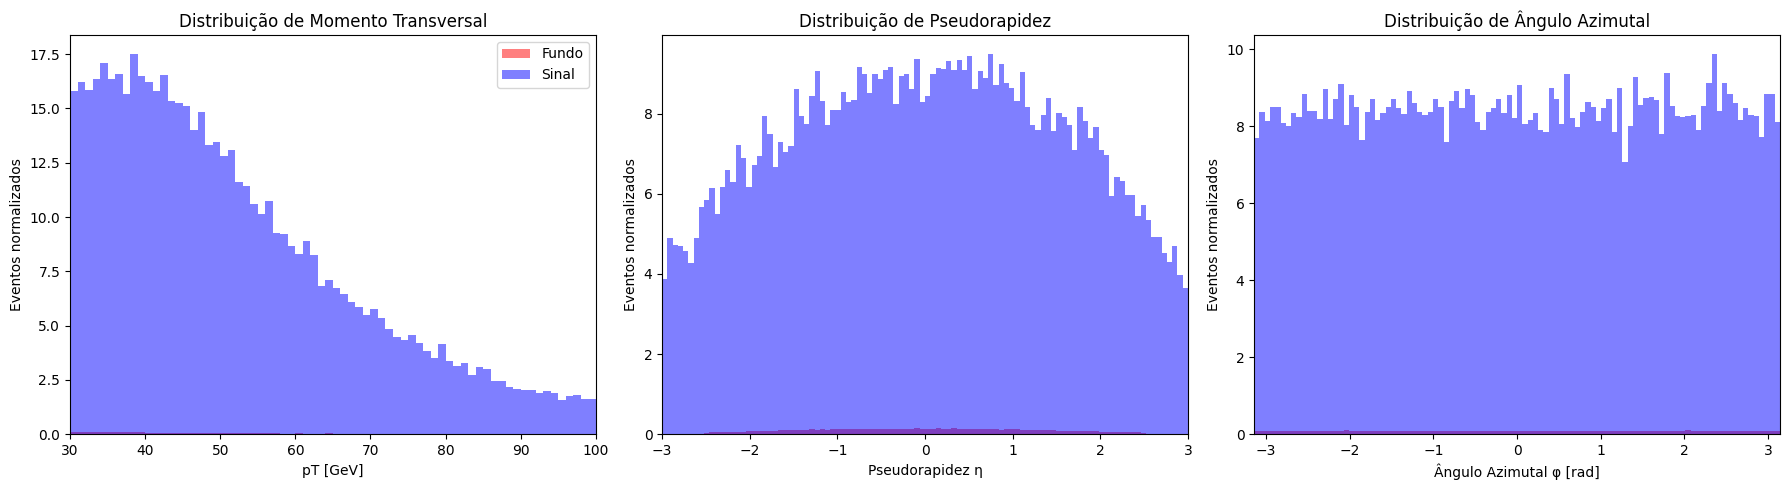

In [234]:
# Histogramas comparativos normalizados
fig, axs = plt.subplots(1, 3, figsize=(18,5))


df_sinal_cin = compute_kinematics(final_signal)
df_fundo_cin = compute_kinematics(final_background)

# --- pT ---
axs[0].hist(df_fundo_cin["pT"], bins=100, range=(0,100), alpha=0.5, color="red",
            weights=np.ones_like(df_fundo_cin["pT"]) * norm_background, label="Fundo")
axs[0].hist(df_sinal_cin ["pT"], bins=100, range=(0,100), alpha=0.5, color="blue",
            weights=np.ones_like(df_sinal_cin ["pT"]) * norm_signal, label="Sinal")
axs[0].set_xlabel("pT [GeV]")
axs[0].set_ylabel("Eventos normalizados")
axs[0].set_title("Distribuição de Momento Transversal")
axs[0].set_xlim(pt_min_opt, 100)
axs[0].legend()

# --- η ---
axs[1].hist(df_fundo_cin["eta"], bins=100, range=(-3,3), alpha=0.5, color="red",
            weights=np.ones_like(df_fundo_cin["eta"]) * norm_background)
axs[1].hist(df_sinal_cin["eta"], bins=100, range=(-3,3), alpha=0.5, color="blue",
            weights=np.ones_like(df_sinal_cin ["eta"]) * norm_signal)
axs[1].set_xlabel("Pseudorapidez η")
axs[1].set_ylabel("Eventos normalizados")
axs[1].set_title("Distribuição de Pseudorapidez")
axs[1].set_xlim(-3, 3)

# --- φ ---
axs[2].hist(df_fundo_cin["phi"], bins=100, range=(-np.pi, np.pi), alpha=0.5, color="red",
            weights=np.ones_like(df_fundo_cin["phi"]) * norm_background)
axs[2].hist(df_sinal_cin ["phi"], bins=100, range=(-np.pi, np.pi), alpha=0.5, color="blue",
            weights=np.ones_like(df_sinal_cin ["phi"]) * norm_signal)
axs[2].set_xlabel("Ângulo Azimutal φ [rad]")
axs[2].set_ylabel("Eventos normalizados")
axs[2].set_title("Distribuição de Ângulo Azimutal")
axs[2].set_xlim(-np.pi, np.pi)

plt.tight_layout()
plt.show()

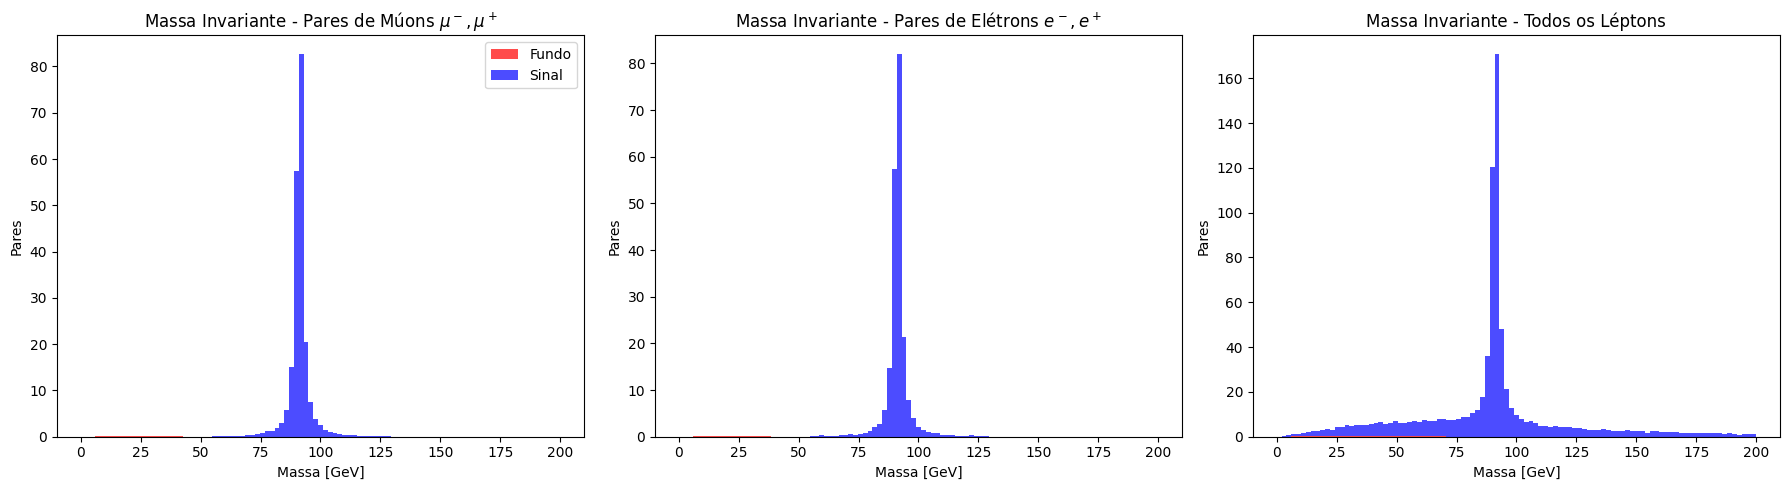

In [235]:

# --- [6] Histogramas combinados: múons, elétrons e todos os léptons ---
def build_mass_histograms_combined(signal_df, background_df):
    # Função auxiliar para calcular massas
    def get_masses_by_type(df):
        leptons = df[df["pid"].isin([11, -11, 13, -13])]
        m_muons, m_electrons, m_leptons = [], [], []
        for evt_id, group in leptons.groupby("event_id"):
            particles = group.to_dict("records")
            # Pares de múons
            muons = [p for p in particles if abs(p["pid"]) == 13]
            for i in range(len(muons)):
                for j in range(i+1, len(muons)):
                    if np.sign(muons[i]["pid"]) != np.sign(muons[j]["pid"]):
                        m_muons.append(invariant_mass(muons[i], muons[j]))
            # Pares de elétrons
            electrons = [p for p in particles if abs(p["pid"]) == 11]
            for i in range(len(electrons)):
                for j in range(i+1, len(electrons)):
                    if np.sign(electrons[i]["pid"]) != np.sign(electrons[j]["pid"]):
                        m_electrons.append(invariant_mass(electrons[i], electrons[j]))
            # Pares de léptons (muons + elétrons)
            for i in range(len(particles)):
                for j in range(i+1, len(particles)):
                    if np.sign(particles[i]["pid"]) != np.sign(particles[j]["pid"]):
                        m_leptons.append(invariant_mass(particles[i], particles[j]))
        return np.array(m_muons), np.array(m_electrons), np.array(m_leptons)

    # Obter massas para sinal e fundo
    m_muons_signal, m_electrons_signal, m_leptons_signal = get_masses_by_type(signal_df)
    m_muons_background, m_electrons_background, m_leptons_background = get_masses_by_type(background_df)

    # Criar figura com 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    bins = np.linspace(0, 200, 100)

    # --- Pares de múons ---
    axs[0].hist([m_muons_background, m_muons_signal], bins=bins, stacked=True,
         weights=[np.ones_like(m_muons_background)*norm_background,
                  np.ones_like(m_muons_signal)*norm_signal],
         color=["red", "blue"], alpha=0.7, label=["Fundo", "Sinal"])

    axs[0].set_title("Massa Invariante - Pares de Múons "+r"$\mu^-,\mu^+$")
    axs[0].set_xlabel("Massa [GeV]")
    axs[0].set_ylabel("Pares")
    axs[0].legend()

    # --- Pares de elétrons ---
    axs[1].hist([m_electrons_background, m_electrons_signal], bins=bins, stacked=True,
         weights=[np.ones_like(m_electrons_background)*norm_background,
                  np.ones_like(m_electrons_signal)*norm_signal],
         color=["red", "blue"], alpha=0.7, label=["Fundo", "Sinal"])
    axs[1].set_title("Massa Invariante - Pares de Elétrons "+r"$e^-,e^+$")
    axs[1].set_xlabel("Massa [GeV]")
    axs[1].set_ylabel("Pares")

    # --- Pares de léptons (muons + elétrons) ---
    axs[2].hist([m_leptons_background, m_leptons_signal], bins=bins, stacked=True,
         weights=[np.ones_like(m_leptons_background)*norm_background,
                  np.ones_like(m_leptons_signal)*norm_signal],
         color=["red", "blue"], alpha=0.7, label=["Fundo", "Sinal"])
    axs[2].set_title("Massa Invariante - Todos os Léptons")
    axs[2].set_xlabel("Massa [GeV]")
    axs[2].set_ylabel("Pares")

    plt.tight_layout()
    plt.show()

# Chamar função para sinal e fundo filtrados
build_mass_histograms_combined(final_signal, final_background)

# [8] COMENTÁRIOS

## Proporção entre histogramas normalizados
A normalização baseada na seção de choque (σ) e luminosidade (L) faz sentido pois como a seção de choque do sinal é aproximandamente 97,5 vezes maior que a seção de choque do fundo, a normalização utilizando essa seção e a mesma Luminosidade integrada em 1 anotem o efeito esperado de ressaltar os dados do sinal e reduzir as contagens do fundo.

## Estrutura nas distribuições de massa invariante

Pose se observar nos dados do sinal claramente o pisco de massa invariante em torno de 91 GeV, caracteristico dà ressonância do bóson Z decaidos em léptosn.

No grafico da massa invariante combinada dos léptons, podemos observar uma calda que se forma além do pico em 91 GeV. Esse comportamento é consistente com um limiar cinemático típico quando dois bósons massivos podem ser produzidos on-shell. Isso pode estar presente para dados simulados em programas mais avançados.

Mas como não é visto este tipo de propagação para massas com energias muito diferentes de 91 GeV para os gráficos de combinações de pares de múons e elétrosns individuais, apenas quando fazemos a combinação de todos os léptons como um todo, outro motivo pode ser mais um efeito do tratamento de dados do que físico. A combinação de todos os léptons possíveis reduzem a resolução do sinal do bózon Z detectado.

# COMPARAÇÃO ENTRE MÉTODOS DE LEITURA

Com ambos os formatos de tratamento de dados podem ser obtido resultados condizentes, no entando a biblioteca pylhe tem funções que facilitam a aplicação de filtros e a realização de operações com as propriedades tiradas do arquivo .LHE. Ao passo de que o tratamento utilizando um dataframe necessitou o desenvolvimento de funções ao decorrer da necessidade de um valor.

A maior parte da diferença entre os graficos veio de parametros de plotágem dos histogramas (como o número de bins) ou de abordagens de contagens com base em eventos, particulas ou pares de partículas.